In [3]:
# !pip install pandas
# !pip install statsmodels
# !pip install matplotlib
#pip install skforecast
#!pip install seaborn
#pip install xgboost

## Importación Librerias

In [4]:
import pandas as pd
import requests
from io import BytesIO
from io import StringIO
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import calendar
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from skforecast.model_selection import grid_search_forecaster
from datetime import datetime
from sklearn import metrics  # Para scikit-learn
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer

## Importación bases cliente

In [5]:
# URL del repositorio en GitHub
repo_url = 'https://api.github.com/repos/Pacheco-Carvajal/GPA-Data-ElectroDunas/contents/'

# Haz una solicitud GET a la API de GitHub para obtener la lista de archivos en el directorio
response = requests.get(repo_url)
file_data = response.json()

# Filtra los archivos que contienen "datos cliente" en su nombre
desired_files = [(file['download_url'], file['name']) for file in file_data if 'DATOSCLIENTE' in file['name']]

# Crea un DataFrame combinando todos los archivos encontrados
dfs = []
for file_url, file_name in desired_files:
    response = requests.get(file_url)
    content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(content))

    # Agrega una columna "fuente" con el nombre del archivo
    df['fuente'] = file_name

    dfs.append(df)

# Concatena los DataFrames en uno solo
result_df = pd.concat(dfs, ignore_index=True)

## Importación sector clientes

In [6]:
# URL cruda del archivo en GitHub
url = "https://github.com/Pacheco-Carvajal/GPA-Data-ElectroDunas/raw/main/sector_economico_clientes.xlsx"

# Cargar el archivo Excel en un DataFrame
sectores = pd.read_excel(url)

# Mostrar las primeras filas del DataFrame
sectores.head()

,Cliente:,Sector Económico:
0,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,Cliente 2,Elaboración de cacao y chocolate y de producto...
2,Cliente 3,Elaboración de cacao y chocolate y de producto...
3,Cliente 4,Elaboración de cacao y chocolate y de producto...
4,Cliente 5,Elaboración de cacao y chocolate y de producto...


In [7]:
# Extraer los números de la columna 'fuente'
result_df['fuente'] = result_df['fuente'].str.extract('(\d+)')

# Concatenar 'Cliente' con los números extraídos
result_df['fuente'] = 'Cliente ' + result_df['fuente']

result_df.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,fuente
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1


In [8]:
result_df = result_df.rename(columns={'fuente': 'Cliente'})
sectores = sectores.rename(columns={'Cliente:': 'Cliente'})
sectores['Cliente'] = sectores['Cliente'].str.strip()

In [9]:
result_df = pd.merge(result_df, sectores[['Cliente', 'Sector Económico:']], on='Cliente', how='left')
result_df.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico:
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...


In [10]:
result_df = result_df.rename(columns={'Sector Económico:': 'Sector Económico'})
result_df['Fecha'] = pd.to_datetime(result_df['Fecha'])
#Impuación a cero
result_df['Active_energy'] = result_df['Active_energy'].apply(lambda x: 0 if x < 0 else x)

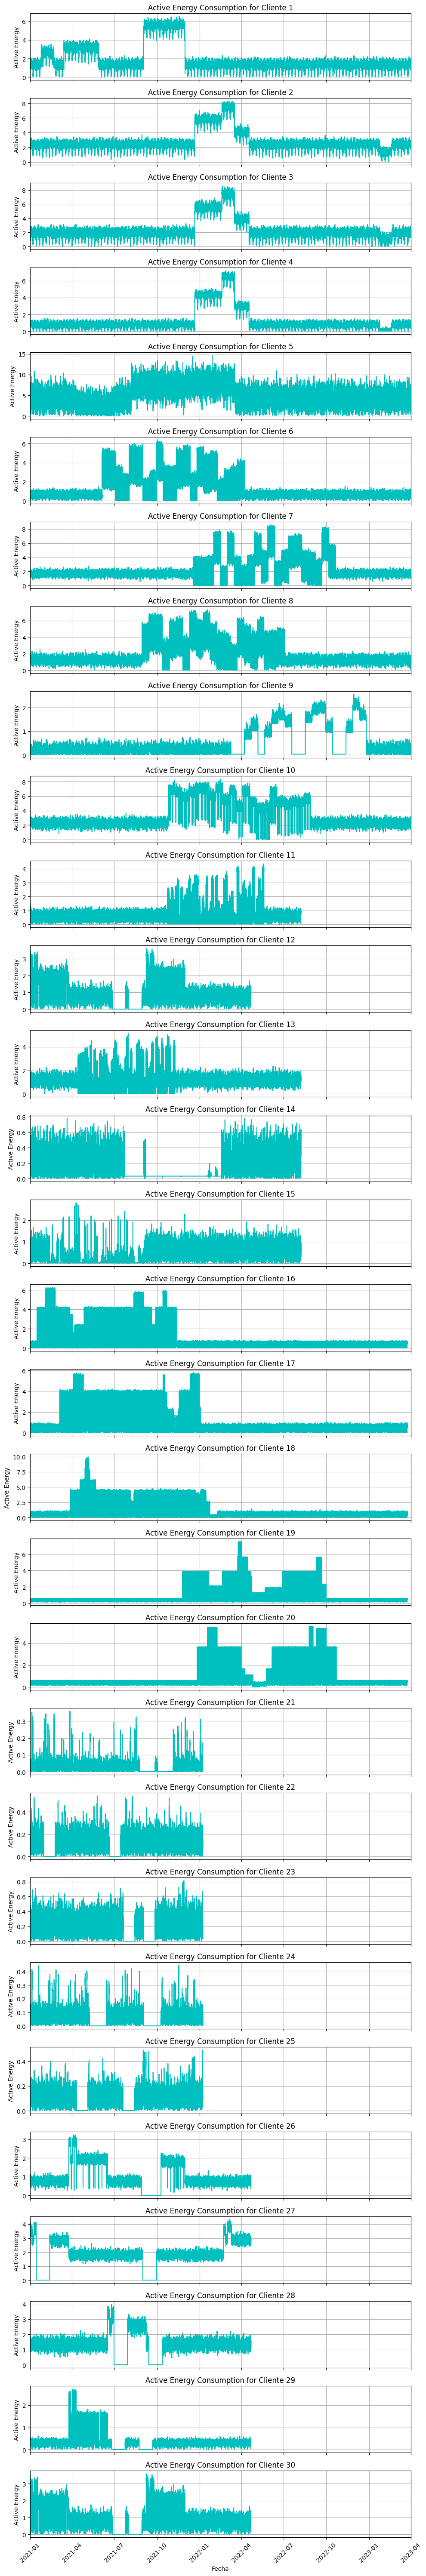

In [11]:
# Suponiendo que 'result_df' es tu DataFrame y ya está cargado correctamente
# Asegúrate de que 'Fecha' está en formato de fecha si no está convertido aún
result_df['Fecha'] = pd.to_datetime(result_df['Fecha'])

# Encuentra los límites del eje x para todos los subplots
fecha_min = result_df['Fecha'].min()
fecha_max = result_df['Fecha'].max()

# Preparar la figura y los ejes
fig, axes = plt.subplots(nrows=30, ncols=1, figsize=(10, 60), sharex=True)  # 30 gráficos, uno por cada cliente

# Iterar sobre cada uno de los clientes
for i, cliente in enumerate(sorted(result_df['Cliente'].unique(), key=lambda x: int(x.split()[1])), start=0):
    # Filtrar el DataFrame por cliente
    df_temp = result_df[result_df['Cliente'] == cliente]
    
    # Trama en el subplot correspondiente
    ax = axes[i]
    ax.plot(df_temp['Fecha'], df_temp['Active_energy'], label=f'{cliente}', color='c')
    ax.set_title(f'Active Energy Consumption for {cliente}')
    ax.set_ylabel('Active Energy')
    ax.grid(True)

# Ajustar el eje x para mostrar fechas adecuadamente
axes[-1].set_xlim([fecha_min, fecha_max])  # Ajusta el eje x en el último subplot, que se aplica a todos
axes[-1].set_xlabel('Fecha')
plt.xticks(rotation=45)
plt.tight_layout()  # Optimizar el espaciado entre gráficos

# Mostrar el gráfico
plt.show()


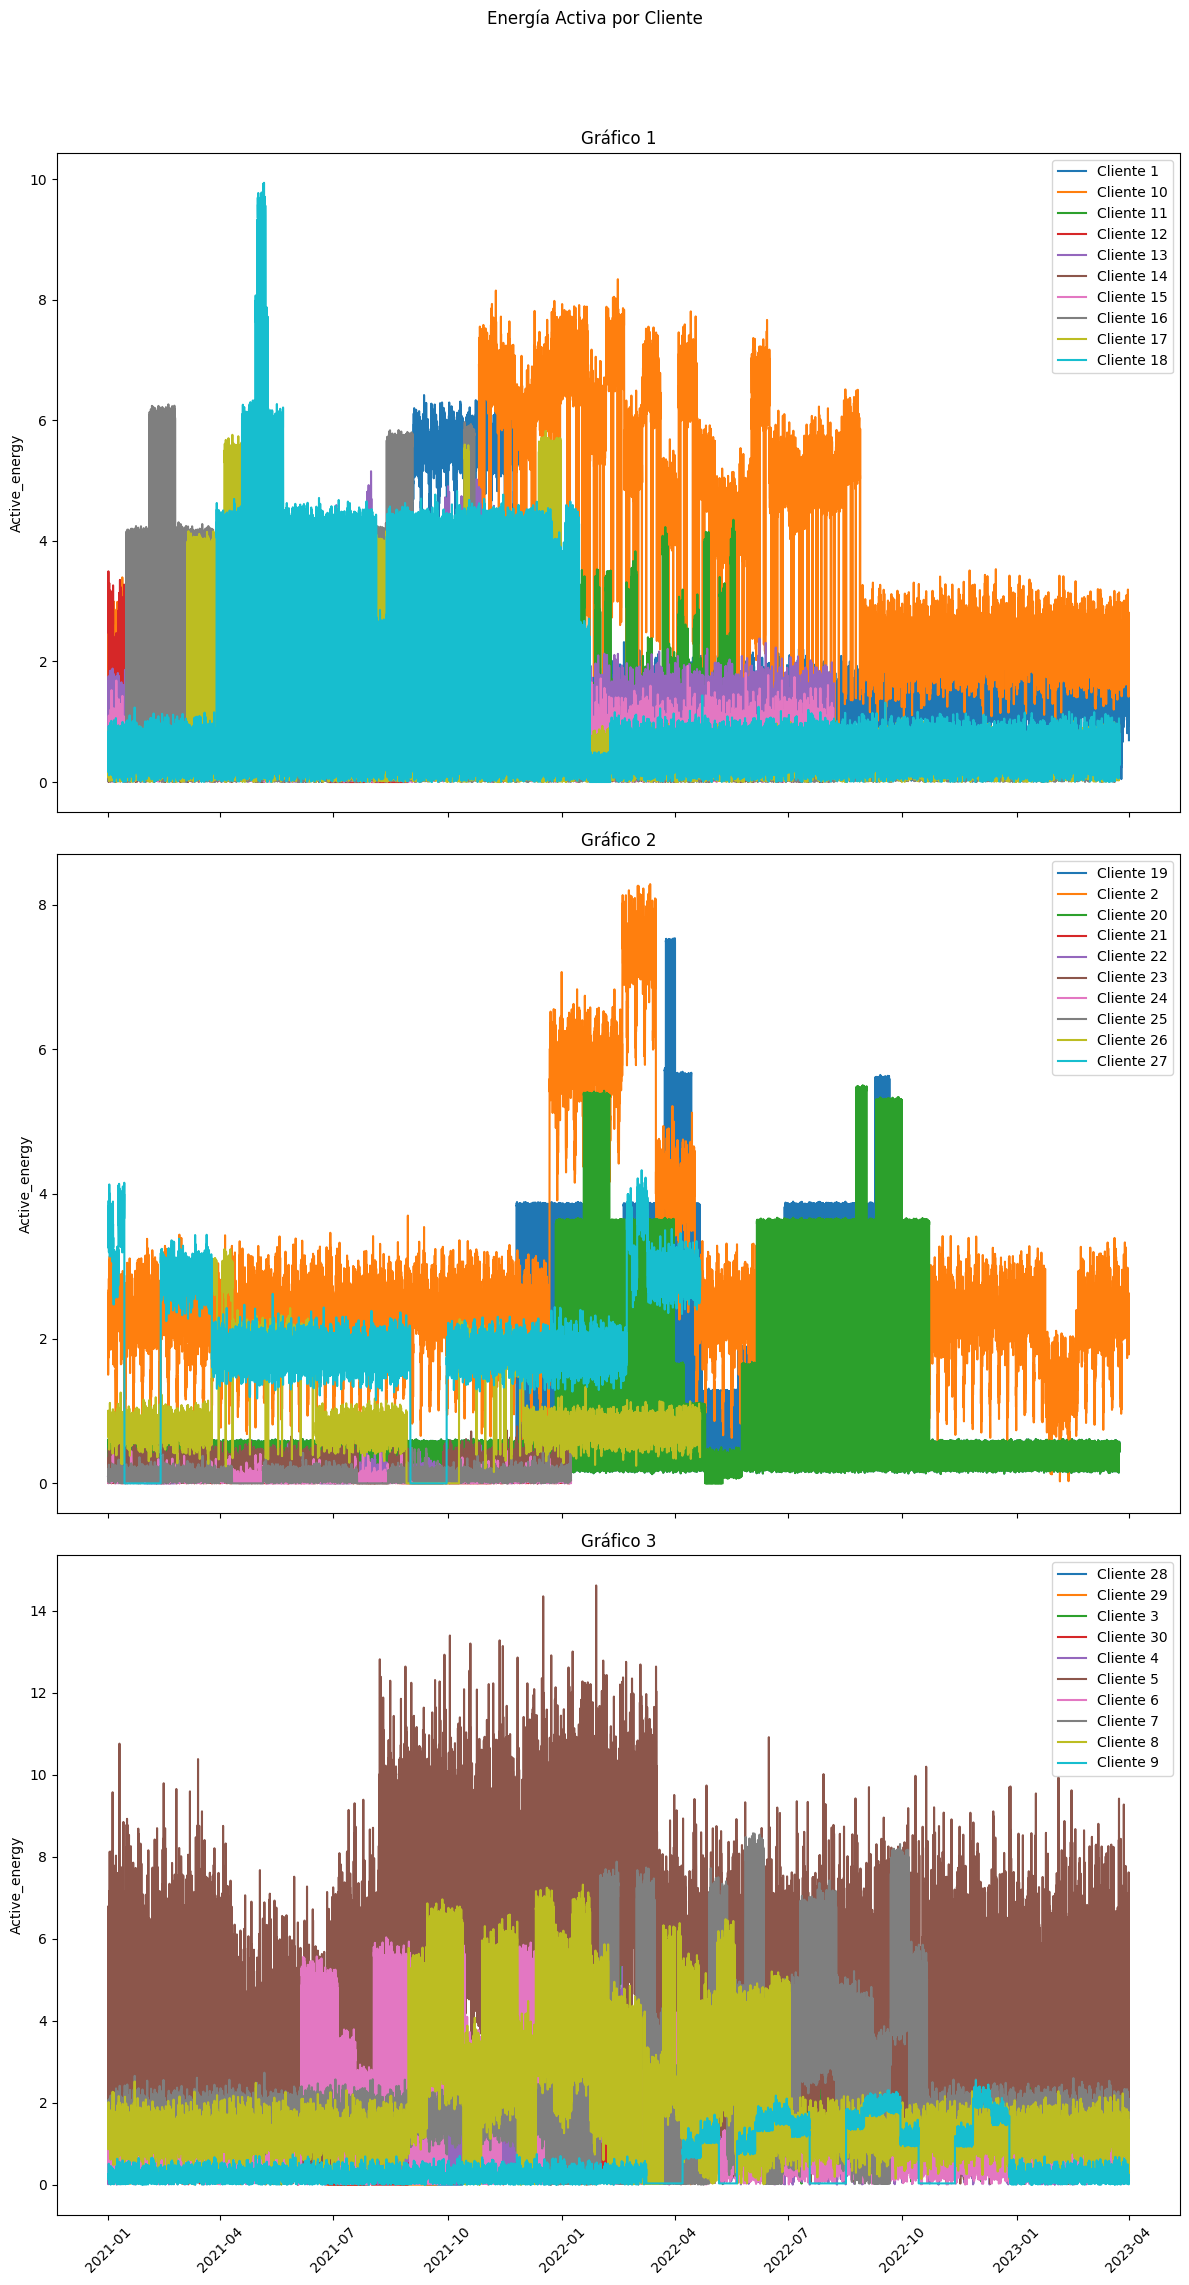

In [12]:

# Suponiendo que 'result_df' es tu DataFrame con las columnas proporcionadas y está ordenado por fecha

# Obtener una lista de clientes únicos
clientes_unicos = result_df['Cliente'].unique()

# Dividir la lista de clientes en grupos de 10
clientes_grupos = [clientes_unicos[i:i+10] for i in range(0, len(clientes_unicos), 10)]

# Configurar los gráficos
num_graficos = len(clientes_grupos)
fig, axs = plt.subplots(num_graficos, 1, figsize=(12, 8*num_graficos), sharex=True)
fig.suptitle('Energía Activa por Cliente')

# Graficar cada grupo de clientes en un gráfico separado
for i, grupo in enumerate(clientes_grupos):
    axs[i].set_ylabel('Active_energy')
    axs[i].set_title(f'Gráfico {i+1}')
    for cliente in grupo:
        datos_cliente = result_df[result_df['Cliente'] == cliente]
        axs[i].plot(datos_cliente['Fecha'], datos_cliente['Active_energy'], label=cliente)
    axs[i].legend()

# Rotar etiquetas del eje x para mejor visualización en el último gráfico
plt.setp(axs[-1].xaxis.get_majorticklabels(), rotation=45)

# Mostrar gráficos
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [13]:
# Seleccionar solo la columna 'Active_energy' y la columna 'Cliente' para mantener la información del cliente
active_energy_by_client = result_df[['Cliente', 'Active_energy']]

# Agrupar por cliente y obtener el resumen estadístico
clientes_describe = active_energy_by_client.groupby('Cliente').describe()

# Ordenar el DataFrame por el valor máximo de 'Active_energy'
clientes_describe_sorted = clientes_describe.sort_values(('Active_energy', 'max'), ascending=False)

# Mostrar el DataFrame ordenado
clientes_describe_sorted

Active_energy                                                    \
                   count      mean       std       min       25%       50%   
Cliente                                                                      
Cliente 5        19681.0  4.998897  2.440656  0.004968  3.248524  4.779127   
Cliente 18       19500.0  1.433431  1.759566  0.000000  0.339010  0.652623   
Cliente 7        19681.0  2.426154  1.791167  0.000037  1.452873  1.791660   
Cliente 3        19681.0  2.341707  1.458767  0.001658  1.629029  2.016040   
Cliente 10       19681.0  3.545042  1.854900  0.011014  2.142763  2.564699   
Cliente 2        19681.0  2.745060  1.368205  0.027246  2.105917  2.466698   
Cliente 19       19500.0  1.129092  1.432507  0.127157  0.290365  0.550787   
Cliente 8        19681.0  1.579517  1.229197  0.000250  0.941429  1.277382   
Cliente 4        19681.0  1.270241  1.395533  0.000240  0.588655  0.875916   
Cliente 1        19681.0  1.940788  1.449246  0.001715  1.197414  1.494509   
Cliente 6        19681.0  1.407520  1.571658  0.000092  0.426879  0.738173   
Cliente 16       19500.0  1.311767  1.664991  0.000052  0.301177  0.583925   
Cliente 17       19500.0  1.279854  1.534047  0.000000  0.327545  0.618378   
Cliente 20       19500.0  1.086441  1.413696  0.000000  0.231000  0.547359   
Cliente 13       14000.0  0.967254  0.783729  0.001417  0.324044  0.997992   
Cliente 11       14000.0  0.763829  0.791581  0.000620  0.292212  0.541020   
Cliente 27       11415.0  1.870751  0.896604  0.000000  1.643705  1.841252   
Cliente 28       11415.0  1.338501  0.698520  0.000000  1.125700  1.350335   
Cliente 30       11415.0  1.054128  0.793689  0.000000  0.474998  0.854333   
Cliente 12       11415.0  1.054128  0.793689  0.000000  0.474998  0.854333   
Cliente 26       11415.0  1.024692  0.659504  0.000000  0.657796  0.802532   
Cliente 15       14000.0  0.429494  0.375392  0.000106  0.031000  0.359226   
Cliente 29       11415.0  0.296145  0.281160  0.000000  0.198037  0.287116   
Cliente 9        19681.0  0.496010  0.581122  0.000014  0.158866  0.231000   
Cliente 23        8925.0  0.206771  0.142244  0.000000  0.094087  0.209655   
Cliente 14       14000.0  0.171379  0.150261  0.000011  0.031000  0.174064   
Cliente 22        8925.0  0.119089  0.087325  0.000000  0.049028  0.116001   
Cliente 25        8925.0  0.100950  0.075742  0.000000  0.039707  0.097080   
Cliente 24        8925.0  0.065535  0.065195  0.000000  0.017709  0.055565   
Cliente 21        8925.0  0.033676  0.044759  0.000000  0.007479  0.027524   

                                 
                 75%        max  
Cliente                          
Cliente 5   6.660707  14.622644  
Cliente 18  1.025718   9.943944  
Cliente 7   2.976583   8.574905  
Cliente 3   2.385611   8.563269  
Cliente 10  5.225753   8.343834  
Cliente 2   2.788212   8.283679  
Cliente 19  0.592899   7.534833  
Cliente 8   1.733445   7.322165  
Cliente 4   1.104245   7.204313  
Cliente 1   1.892287   6.526612  
Cliente 6   1.800236   6.365392  
Cliente 16  0.721806   6.266824  
Cliente 17  0.866101   5.827472  
Cliente 20  0.581174   5.503240  
Cliente 13  1.323173   5.157014  
Cliente 11  0.885325   4.352005  
Cliente 27  2.184151   4.328475  
Cliente 28  1.563624   3.970402  
Cliente 30  1.748458   3.591291  
Cliente 12  1.748458   3.591291  
Cliente 26  1.693354   3.237979  
Cliente 15  0.693359   2.810176  
Cliente 29  0.354299   2.731480  
Cliente 9   0.491338   2.546763  
Cliente 23  0.302123   0.814156  
Cliente 14  0.231000   0.781830  
Cliente 22  0.172845   0.542551  
Cliente 25  0.146911   0.489633  
Cliente 24  0.092455   0.445964  
Cliente 21  0.039227   0.358380

In [14]:
# Calcula la media por cliente
media_por_cliente = result_df.groupby('Cliente')['Active_energy'].mean()

# Imputa los valores cero con la media correspondiente por cliente
#result_df['Active_energy_ajustada'] = result_df.apply(lambda row: media_por_cliente[row['Cliente']] if row['Active_energy'] == 0 else row['Active_energy'], axis=1)
result_df['Active_energy'] = result_df.apply(lambda row: media_por_cliente[row['Cliente']] if row['Active_energy'] == 0 else row['Active_energy'], axis=1)

In [15]:
#result_df_filtrado = result_df[result_df['Active_energy_ajustada'] == 0]
#result_df_filtrado

In [16]:
result_df

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,Cliente 9,Cultivo de Árboles Frutales y Nueces
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,Cliente 9,Cultivo de Árboles Frutales y Nueces
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,Cliente 9,Cultivo de Árboles Frutales y Nueces
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,Cliente 9,Cultivo de Árboles Frutales y Nueces


## Pruebas estacionariedad para MODEL- BASED

In [17]:
for cliente_id in range(1, 31): 
    # Filtrar el DataFrame para obtener solo las filas correspondientes a este cliente
    cliente_data = result_df[result_df['Cliente'] == f'Cliente {cliente_id}']
    
    # Aplicar la prueba de estacionariedad (ADF) a la serie temporal
    resultado_prueba = adfuller(cliente_data['Active_energy'])
    
    # Resultados de la prueba
    print(f"Cliente {cliente_id}:")
    print("Estadística ADF:", resultado_prueba[0])
    print("Valor p:", resultado_prueba[1])
    print("Valores críticos:", resultado_prueba[4])
    print("Conclusion:", "Los datos son estacionarios." if resultado_prueba[1] < 0.05 else "Los datos no son estacionarios.")
    print()

Cliente 1:
Estadística ADF: -4.174790013551806
Valor p: 0.0007267220985626516
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 2:
Estadística ADF: -4.491405477319599
Valor p: 0.00020379220684839077
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 3:
Estadística ADF: -4.301114208378335
Valor p: 0.000442242958565005
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 4:
Estadística ADF: -3.2227786360354123
Valor p: 0.018703448324354586
Valores críticos: {'1%': -3.4306830865855864, '5%': -2.8616872124135067, '10%': -2.5668483571714216}
Conclusion: Los datos son estacionarios.

Cliente 5:
Estadística ADF: -4.787967121562017
Valor p: 5.7343003032562675e-05
Valores críticos: {'1%': -3.430683086

In [18]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['Cliente', 'Estadística ADF', 'Valor p', 'Conclusion'])

# Iterar sobre los clientes
for cliente_id in range(1, 31):
    # Filtrar el DataFrame para obtener solo las filas correspondientes a este cliente
    cliente_data = result_df[result_df['Cliente'] == f'Cliente {cliente_id}']
    
    # Aplicar la prueba de estacionariedad (ADF) a la serie temporal
    resultado_prueba = adfuller(cliente_data['Active_energy'])
    
    # Determinar si los datos son estacionarios
    estacionario = "Estacionarios" if resultado_prueba[1] < 0.05 else "No estacionarios"
    
    # Guardar los resultados en el DataFrame
    resultados_df.loc[len(resultados_df)] = [cliente_id, resultado_prueba[0], resultado_prueba[1], estacionario]

# Mostrar el DataFrame con los resultados
resultados_df

,Cliente,Estadística ADF,Valor p,Conclusion
0,1,-4.174790,7.267221e-04,Estacionarios
1,2,-4.491405,2.037922e-04,Estacionarios
2,3,-4.301114,4.422430e-04,Estacionarios
3,4,-3.222779,1.870345e-02,Estacionarios
4,5,-4.787967,5.734300e-05,Estacionarios
5,6,-5.212425,8.292827e-06,Estacionarios
6,7,-5.275953,6.139918e-06,Estacionarios
7,8,-6.830971,1.894159e-09,Estacionarios
8,9,-3.127751,2.456652e-02,Estacionarios
9,10,-2.421805,1.356766e-01,No estacionarios


In [19]:
# resultados_df.to_excel('resultados_clientes.xlsx', index=False)

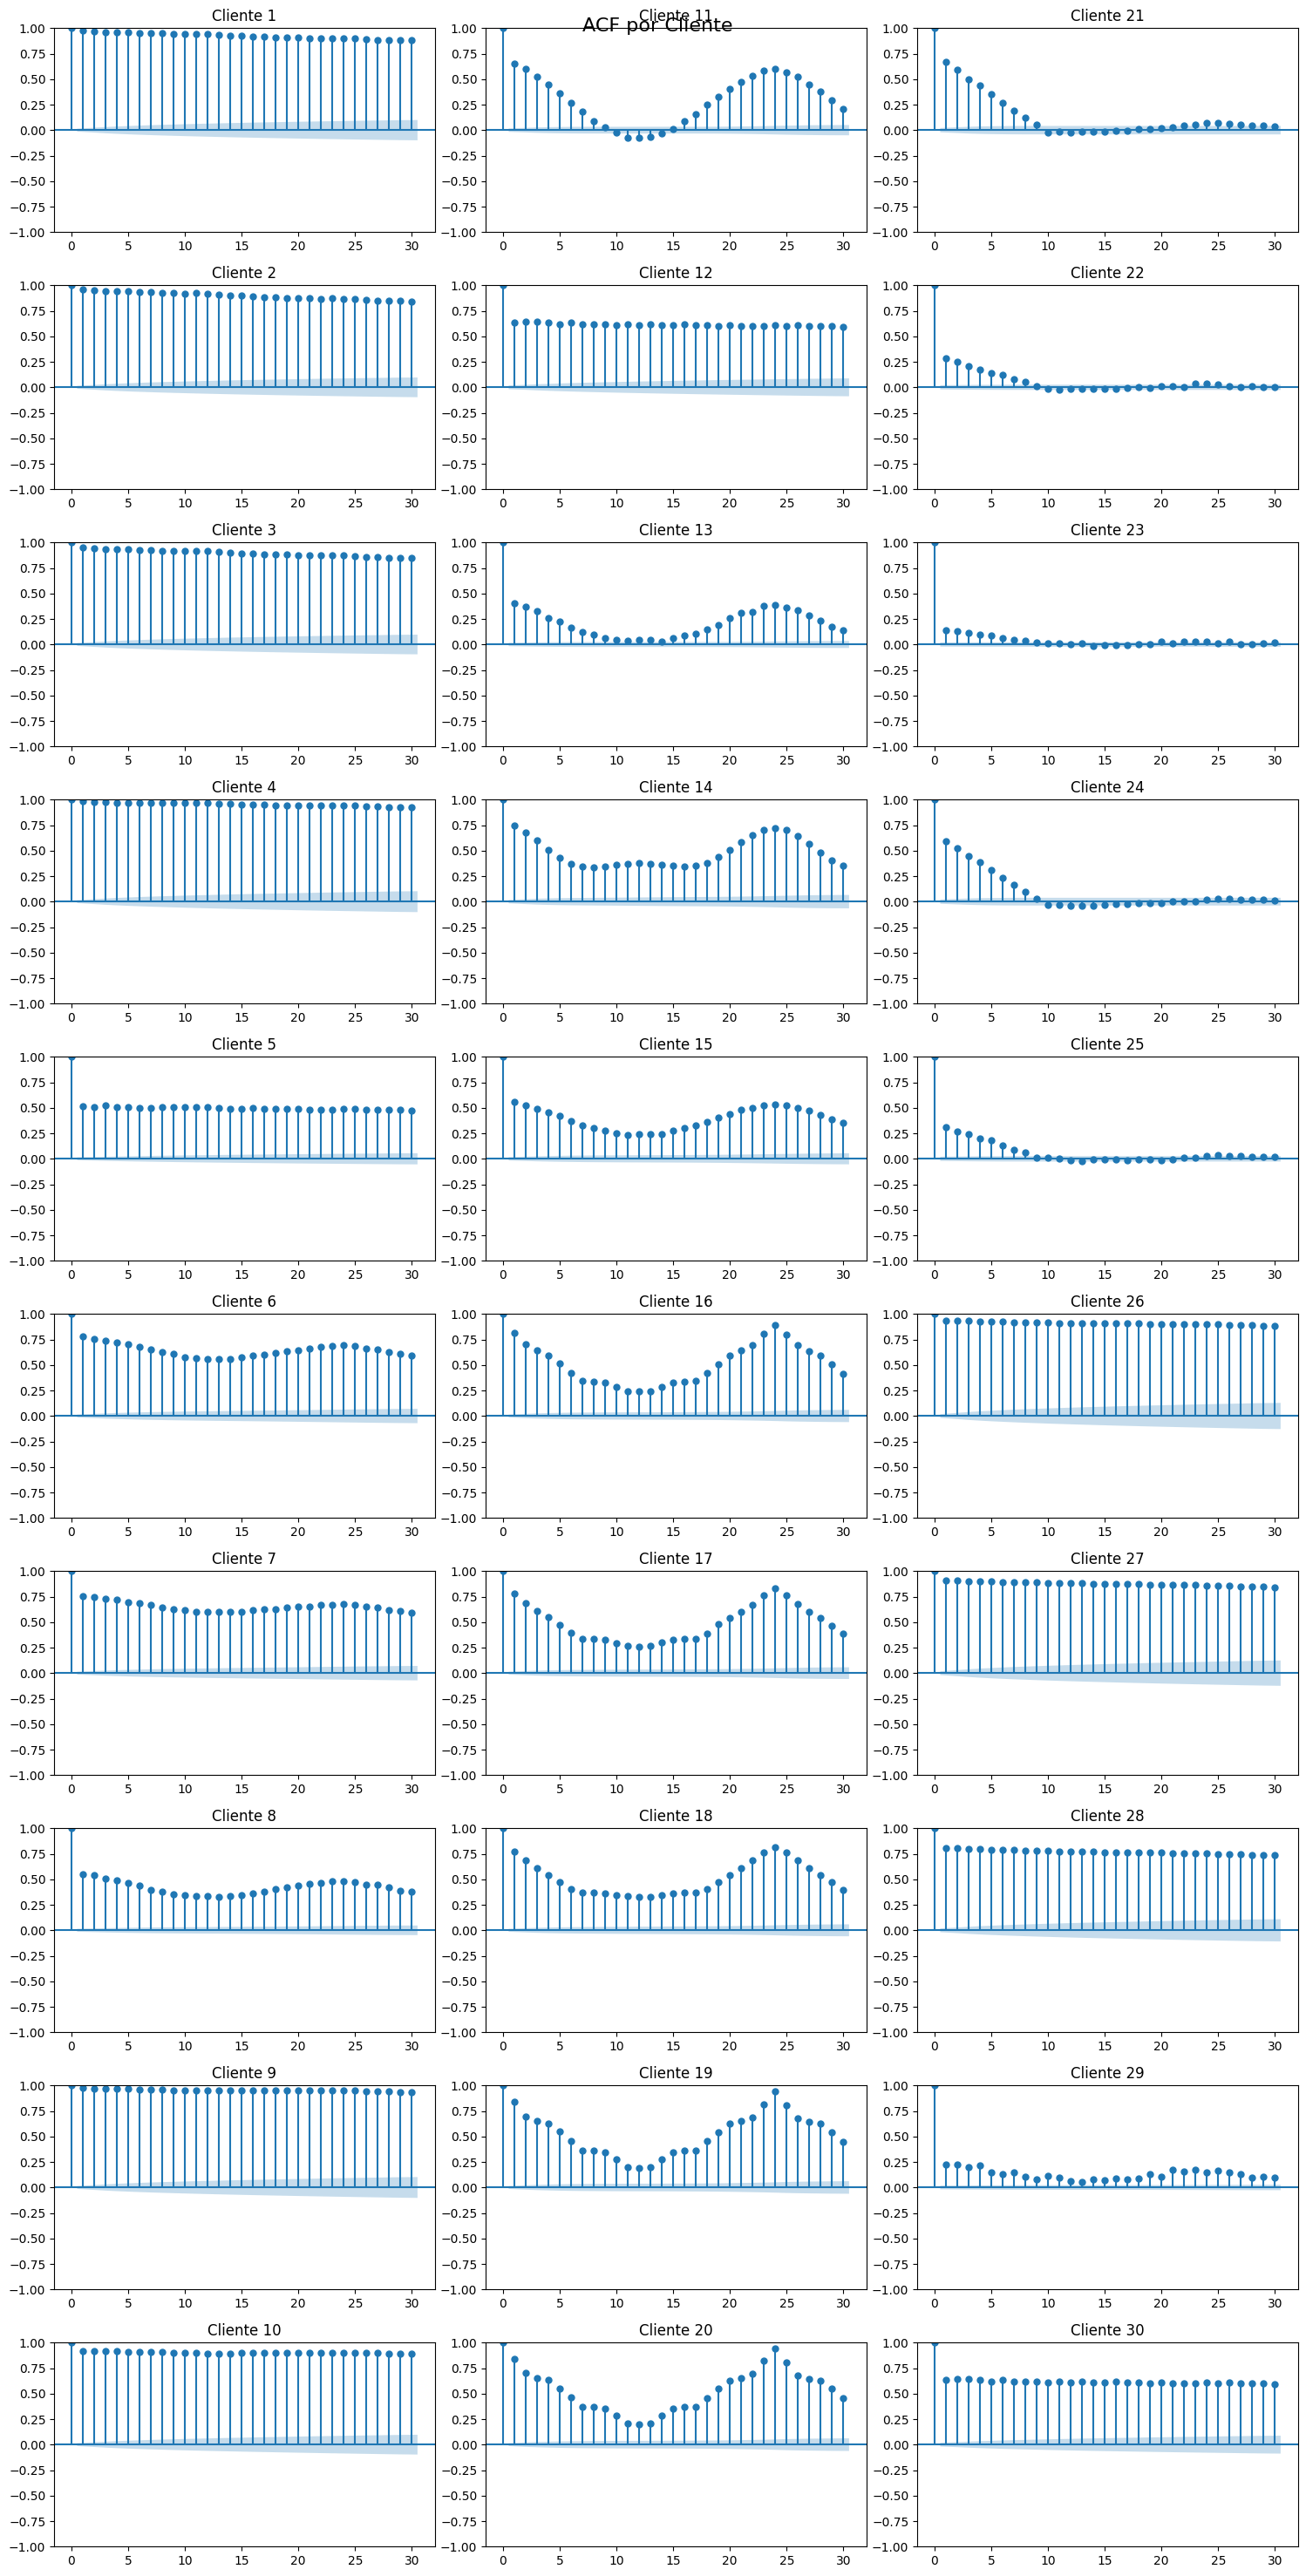

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
# Suponiendo que 'result_df' es tu DataFrame que contiene los datos de consumo de energía por cliente
fig, axes = plt.subplots(10, 3, figsize=(15, 30))
fig.suptitle('ACF por Cliente', fontsize=16)

for cliente_id in range(1, 31):
    # Calcular las coordenadas (fila, columna) en la grilla
    row = (cliente_id - 1) % 10
    col = (cliente_id - 1) // 10

    # Filtrar el DataFrame para obtener solo las filas correspondientes a este cliente
    cliente_data = result_df[result_df['Cliente'] == f'Cliente {cliente_id}']
    
    # Calcular la autocorrelación para la serie temporal de consumo de energía
    autocorrelation = pd.Series.autocorr(cliente_data['Active_energy'])
    
    # Graficar la función de autocorrelación
    plot_acf(cliente_data['Active_energy'], lags=30, ax=axes[row, col])
    axes[row, col].set_title(f'Cliente {cliente_id}')

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

## Selección de cliente a trabajar

In [21]:
numero_cliente = 5
cliente = 'Cliente '+ str(numero_cliente)
result_df[result_df['Cliente']==cliente]
cliente_df = result_df[result_df['Cliente'] == cliente].copy()
# Ordenar los datos por fecha de manera ascendente
cliente_df = cliente_df.sort_values(by='Fecha')
cliente_df


,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico
365020,2021-01-01 00:00:00,4.457443,0.980230,746.016908,709.999466,Cliente 5,Elaboración de cacao y chocolate y de producto...
365021,2021-01-01 01:00:00,4.698414,4.057734,595.329779,679.061180,Cliente 5,Elaboración de cacao y chocolate y de producto...
365022,2021-01-01 02:00:00,3.228533,3.556386,669.818274,646.135216,Cliente 5,Elaboración de cacao y chocolate y de producto...
365023,2021-01-01 03:00:00,2.138653,3.800049,627.849139,656.165111,Cliente 5,Elaboración de cacao y chocolate y de producto...
365024,2021-01-01 04:00:00,2.827120,2.771083,652.307767,580.942897,Cliente 5,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...
384696,2023-03-31 20:00:00,1.351702,5.776986,732.401034,730.731044,Cliente 5,Elaboración de cacao y chocolate y de producto...
384697,2023-03-31 21:00:00,4.803313,3.538812,576.031590,728.442563,Cliente 5,Elaboración de cacao y chocolate y de producto...
384698,2023-03-31 22:00:00,3.203953,5.504941,690.693389,691.430843,Cliente 5,Elaboración de cacao y chocolate y de producto...
384699,2023-03-31 23:00:00,3.330649,2.379746,603.184318,663.736458,Cliente 5,Elaboración de cacao y chocolate y de producto...


In [22]:
# Seleccionar solo las columnas numéricas
columnas_numericas = cliente_df.select_dtypes(include=['int', 'float'])

# Calcular las correlaciones entre las variables numéricas
correlaciones = columnas_numericas.corr()

# Mostrar las correlaciones
print(correlaciones)


                 Active_energy  Reactive_energy  Voltaje_FA  Voltaje_FC
Active_energy         1.000000         0.153794   -0.064120   -0.062137
Reactive_energy       0.153794         1.000000   -0.014966   -0.016807
Voltaje_FA           -0.064120        -0.014966    1.000000    0.917182
Voltaje_FC           -0.062137        -0.016807    0.917182    1.000000


In [23]:
## Metricas de evaluación a emplear

In [24]:
# Definir función de evaluación de métricas
def evaluacion_metrica(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    return mse, mae, rmse, mape, r2

### Construcción base a modelar

In [25]:
data_completa = cliente_df[['Fecha','Active_energy']]
Frecuencia_horas = '12H'
data_completa.set_index('Fecha', inplace=True)

# Resample los datos cada Frecuencia_horas horas y sumar la energía activa
data_completa_diaria = data_completa.resample(Frecuencia_horas).sum()

# Si deseas resetear el índice para que 'Fecha' sea nuevamente una columna
data_completa_diaria.reset_index(inplace=True)

# Ver el DataFrame resultante
data_completa_diaria
data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour
data_completa_diaria.set_index('Fecha', inplace=True)
data_completa_diaria.index.freq = Frecuencia_horas
data_completa_diaria

C:\Users\dhoyoso\AppData\Local\Temp\ipykernel_19640\3822928826.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_completa_diaria = data_completa.resample(Frecuencia_horas).sum()
C:\Users\dhoyoso\AppData\Local\Temp\ipykernel_19640\3822928826.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_completa_diaria.index.freq = Frecuencia_horas


,Active_energy,Month,Hour
Fecha,,,
2021-01-01 00:00:00,45.012793,1,0
2021-01-01 12:00:00,49.435851,1,12
2021-01-02 00:00:00,50.722687,1,0
2021-01-02 12:00:00,56.317324,1,12
2021-01-03 00:00:00,47.135008,1,0
...,...,...,...
2023-03-30 00:00:00,49.610017,3,0
2023-03-30 12:00:00,55.783393,3,12
2023-03-31 00:00:00,56.871019,3,0


In [26]:
data_completa = data_completa_diaria.copy()
data_completa['Active_energy_diff'] = data_completa['Active_energy'].diff()
data_completa = data_completa.dropna()
data_completa

,Active_energy,Month,Hour,Active_energy_diff
Fecha,,,,
2021-01-01 12:00:00,49.435851,1,12,4.423058
2021-01-02 00:00:00,50.722687,1,0,1.286836
2021-01-02 12:00:00,56.317324,1,12,5.594638
2021-01-03 00:00:00,47.135008,1,0,-9.182317
2021-01-03 12:00:00,54.532120,1,12,7.397112
...,...,...,...,...
2023-03-30 00:00:00,49.610017,3,0,-4.886475
2023-03-30 12:00:00,55.783393,3,12,6.173376
2023-03-31 00:00:00,56.871019,3,0,1.087626


In [27]:
n_rezagos_nivel = 30
for i in range(1, n_rezagos_nivel):#Rezagos del nivel
    data_completa[f'L{i}'] = data_completa['Active_energy'].shift(i)
    
n_rezagos_diferencia = 30
for i in range(1, n_rezagos_diferencia):#Rezagos de la diferencia
    data_completa[f'L{i}_diff'] = data_completa['Active_energy_diff'].shift(i)

data_completa.drop(columns=['Active_energy_diff'], inplace=True) #Se elimina la diferencia original
data_completa = data_completa.dropna()
data_completa

,Active_energy,Month,Hour,L1,L2,L3,L4,L5,L6,L7,...,L20_diff,L21_diff,L22_diff,L23_diff,L24_diff,L25_diff,L26_diff,L27_diff,L28_diff,L29_diff
Fecha,,,,,,,,,,,,,,,,,,,,,
2021-01-16 00:00:00,60.631889,1,0,66.104962,53.257416,44.651658,37.859007,36.794928,52.092075,51.554936,...,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317,5.594638,1.286836,4.423058
2021-01-16 12:00:00,59.815257,1,12,60.631889,66.104962,53.257416,44.651658,37.859007,36.794928,52.092075,...,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317,5.594638,1.286836
2021-01-17 00:00:00,45.619522,1,0,59.815257,60.631889,66.104962,53.257416,44.651658,37.859007,36.794928,...,-4.186225,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317,5.594638
2021-01-17 12:00:00,60.977079,1,12,45.619522,59.815257,60.631889,66.104962,53.257416,44.651658,37.859007,...,-5.468865,-4.186225,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112,-9.182317
2021-01-18 00:00:00,49.180185,1,0,60.977079,45.619522,59.815257,60.631889,66.104962,53.257416,44.651658,...,15.189525,-5.468865,-4.186225,-7.125371,3.886722,5.109332,-7.491358,-3.669908,4.194961,7.397112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-30 00:00:00,49.610017,3,0,54.496492,61.465362,59.525148,65.923621,66.929454,50.334115,54.746687,...,3.186706,-0.137077,14.522628,-7.829552,-17.213508,-0.547988,11.636443,-3.637424,-4.865831,6.722735
2023-03-30 12:00:00,55.783393,3,12,49.610017,54.496492,61.465362,59.525148,65.923621,66.929454,50.334115,...,-0.391123,3.186706,-0.137077,14.522628,-7.829552,-17.213508,-0.547988,11.636443,-3.637424,-4.865831
2023-03-31 00:00:00,56.871019,3,0,55.783393,49.610017,54.496492,61.465362,59.525148,65.923621,66.929454,...,0.378572,-0.391123,3.186706,-0.137077,14.522628,-7.829552,-17.213508,-0.547988,11.636443,-3.637424


## División Base campos dependietes e Independientes y partición en datos de entrenamiento y test

In [28]:
X2= data_completa.iloc[:,1:]
Y2= data_completa.iloc[:,0]
print(X2.head(),Y2.head())

                     Month  Hour         L1         L2         L3         L4  \
Fecha                                                                          
2021-01-16 00:00:00      1     0  66.104962  53.257416  44.651658  37.859007   
2021-01-16 12:00:00      1    12  60.631889  66.104962  53.257416  44.651658   
2021-01-17 00:00:00      1     0  59.815257  60.631889  66.104962  53.257416   
2021-01-17 12:00:00      1    12  45.619522  59.815257  60.631889  66.104962   
2021-01-18 00:00:00      1     0  60.977079  45.619522  59.815257  60.631889   

                            L5         L6         L7         L8  ...  \
Fecha                                                            ...   
2021-01-16 00:00:00  36.794928  52.092075  51.554936  62.300875  ...   
2021-01-16 12:00:00  37.859007  36.794928  52.092075  51.554936  ...   
2021-01-17 00:00:00  44.651658  37.859007  36.794928  52.092075  ...   
2021-01-17 12:00:00  53.257416  44.651658  37.859007  36.794928  ...   
2021-01

In [29]:
# Calcular el índice que divide los datos en 70% de entrenamiento y 30% de prueba
traintarget_size = int(0.8 * len(Y2))
traintarget_size = int(len(Y2) * 0.80)   # Set split
train_target, test_target = Y2[0:traintarget_size], Y2[traintarget_size:len(Y2)]

print('Observaciones para el objetivo: %d' % (len(Y2)))
print('Observaciones de entrenamiento para el objetivo: %d' % (len(train_target)))
print('Observaciones de prueba para el objetivo: %d' % (len(test_target)))

trainfeature_size = int(len(X2) * 0.80)
train_feature, test_feature = X2[0:trainfeature_size], X2[trainfeature_size:len(X2)]
print('Observaciones para la característica: %d' % (len(X2)))
print('Observaciones de entrenamiento para la característica: %d' % (len(train_feature)))
print('Observaciones de prueba para la característica: %d' % (len(test_feature)))

Observaciones para el objetivo: 1611
Observaciones de entrenamiento para el objetivo: 1288
Observaciones de prueba para el objetivo: 323
Observaciones para la característica: 1611
Observaciones de entrenamiento para la característica: 1288
Observaciones de prueba para la característica: 323


## Modelo Random Forest inicial

In [30]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con 500 árboles
rfr = RandomForestRegressor(n_estimators=500,n_jobs=-1)

# Entrenamos el modelo
rfr.fit(train_feature, train_target)

# Hacemos las predicciones 
fcst = rfr.predict(test_feature)

In [31]:
b=pd.DataFrame({"Actual":test_target, "Random Forest":fcst})
b

,Actual,Random Forest
Fecha,,
2022-10-22 00:00:00,43.452680,43.555642
2022-10-22 12:00:00,33.054786,45.582044
2022-10-23 00:00:00,44.379023,43.444951
2022-10-23 12:00:00,51.204228,47.348556
2022-10-24 00:00:00,62.034365,55.426818
...,...,...
2023-03-30 00:00:00,49.610017,52.485733
2023-03-30 12:00:00,55.783393,53.218167
2023-03-31 00:00:00,56.871019,53.713420


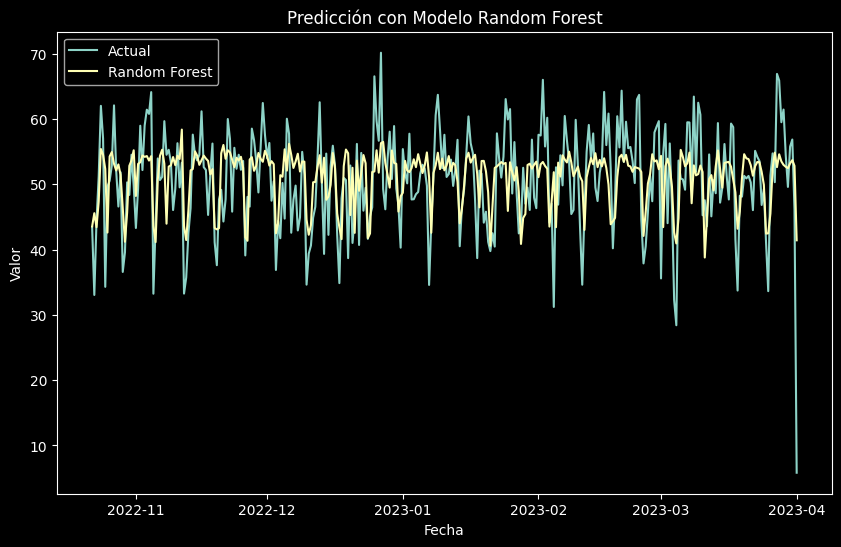

In [32]:
# Configurando el estilo oscuro similar al 'plotly_dark'
plt.style.use('dark_background')

# Creando la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))  # Puedes ajustar el tamaño de la figura según tus necesidades

# Dibujando cada columna del DataFrame
for column in b.columns:
    ax.plot(b.index, b[column], label=column)

# Configurando el título y las etiquetas
ax.set_title("Predicción con Modelo Random Forest")
ax.set_xlabel("Fecha")  # Asumiendo que el índice es de tipo fecha
ax.set_ylabel("Valor")

# Añadiendo una leyenda
ax.legend()

# Mostrar la gráfica
plt.show()

In [33]:
data_completa = cliente_df[['Fecha','Active_energy']]
data_completa.set_index('Fecha', inplace=True)
data_completa

,Active_energy
Fecha,
2021-01-01 00:00:00,4.457443
2021-01-01 01:00:00,4.698414
2021-01-01 02:00:00,3.228533
2021-01-01 03:00:00,2.138653
2021-01-01 04:00:00,2.827120
...,...
2023-03-31 20:00:00,1.351702
2023-03-31 21:00:00,4.803313
2023-03-31 22:00:00,3.203953


In [34]:
# # Iterar sobre diferentes frecuencias y rezagos
# frecuencias = ['1H', '8H', '12H']
# rezagos = [15, 30]

# # Seleccionar solo el 90% de los datos
# data_completa = data_completa.iloc[:int(0.9 * len(data_completa))]

# # Crear una lista para almacenar los resultados
# resultados = []

# # Iterar sobre diferentes frecuencias
# for frecuencia in frecuencias:
#     # Resample los datos a la frecuencia especificada y sumar la energía activa
#     data_completa_diaria = data_completa.resample(frecuencia).sum()
    
#     # Reiniciar el índice para que 'Fecha' sea una columna nuevamente
#     data_completa_diaria.reset_index(inplace=True)
    
#     # Agregar columnas de mes y hora
#     data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
#     data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour
    
#     # Establecer el índice en 'Fecha' y la frecuencia
#     data_completa_diaria.set_index('Fecha', inplace=True)
#     data_completa_diaria.index.freq = frecuencia
    
#     # Eliminar filas con valores NaN
#     data_completa_diaria.dropna(inplace=True)
    
#     # Iterar sobre diferentes rezagos
#     for rezago in rezagos:
#         # Crear columnas de rezagos para los datos
#         data_completa_diaria[f'L{rezago}'] = data_completa_diaria['Active_energy'].shift(rezago)
        
#         # Eliminar filas con valores NaN
#         data_completa_diaria.dropna(inplace=True)

#         # Definir variables predictoras (X) y variable objetivo (Y)
#         X = data_completa_diaria.iloc[:, 1:]
#         Y = data_completa_diaria.iloc[:, 0]

#         # Dividir datos en entrenamiento y prueba (70% entrenamiento, 20% prueba)
#         X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#         # Crear y entrenar modelo de Random Forest
#         modelo = 'Random Forest'
#         rfr = RandomForestRegressor(n_estimators=500, n_jobs=-1)
#         rfr.fit(X_train, Y_train)

#         # Hacer predicciones
#         predictions = rfr.predict(X_test)

#         # Evaluar métricas de rendimiento
#         mse, mae, rmse, mape, r2 = evaluacion_metrica(Y_test, predictions)
        
#         # Almacenar resultados en la lista
#         resultados.append({
#             'Frecuencia': frecuencia,
#             'Rezago': rezago,
#             'Modelo': modelo,
#             'MSE': mse,
#             'MAE': mae,
#             'RMSE': rmse,
#             'MAPE': mape,
#             'R2': r2,
#             'Len_train': len(X_train),
#             'Len_test': len(X_test),
#             'Len_total': len(data_completa_diaria)
#         })

# # Convertir la lista de resultados en un DataFrame
# resultados_df = pd.DataFrame(resultados)

# # Mostrar resultados
# resultados_df


In [35]:
evaluacion_metrica(test_target,fcst)

(44.02538258486372,
 5.225048073369871,
 6.635162589180744,
 12.527779694102975,
 0.2795600235910084)

In [36]:
# Definir la función de evaluación de métricas
def evaluacion_metrica(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calcular métricas
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    # Devolver métricas como un diccionario
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }


In [37]:
# Iterar sobre cada cliente
resultados_totales = []  # Lista para almacenar los resultados de todos los clientes

for numero_cliente in range(1, 4):
    cliente = 'Cliente ' + str(numero_cliente)
    cliente_df = result_df[result_df['Cliente'] == cliente].copy()
    
    # Ordenar los datos por fecha de manera ascendente
    cliente_df = cliente_df.sort_values(by='Fecha')
    
    # Obtener la columna de 'Active_energy' y establecer 'Fecha' como índice
    data_completa = cliente_df[['Fecha', 'Active_energy']]
    data_completa.set_index('Fecha', inplace=True)
    
    # Iterar sobre diferentes frecuencias y rezagos
    frecuencias = ['1H', '8H', '12H']
    rezagos = [15, 30]

    # Seleccionar solo el 90% de los datos
    data_completa = data_completa.iloc[:int(0.9 * len(data_completa))]

    # Crear una lista para almacenar los resultados
    resultados_cliente = []

    for frecuencia in frecuencias:
        # Resample los datos a la frecuencia especificada y sumar la energía activa
        data_completa_diaria = data_completa.resample(frecuencia).sum()

        # Reiniciar el índice para que 'Fecha' sea una columna nuevamente
        data_completa_diaria.reset_index(inplace=True)

        # Agregar columnas de mes y hora
        data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
        data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour

        # Establecer el índice en 'Fecha' y la frecuencia
        data_completa_diaria.set_index('Fecha', inplace=True)
        data_completa_diaria.index.freq = frecuencia

        # Eliminar filas con valores NaN
        data_completa_diaria.dropna(inplace=True)

        for rezago in rezagos:
            # Crear columnas de rezagos para los datos
            data_completa_diaria[f'L{rezago}'] = data_completa_diaria['Active_energy'].shift(rezago)

            # Eliminar filas con valores NaN
            data_completa_diaria.dropna(inplace=True)

            # Definir variables predictoras (X) y variable objetivo (Y)
            X = data_completa_diaria.iloc[:, 1:]
            Y = data_completa_diaria.iloc[:, 0]

            # Dividir datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

            # Crear y entrenar modelo de Random Forest
            modelo = 'Random Forest'
            rfr = RandomForestRegressor(n_estimators=500, n_jobs=-1)
            rfr.fit(X_train, Y_train)

            # Hacer predicciones
            predictions = rfr.predict(X_test)

            # Evaluar métricas de rendimiento
            metricas = evaluacion_metrica(Y_test, predictions)
            
            # Almacenar resultados en la lista
            resultados_cliente.append({
                'Cliente': cliente,
                'Frecuencia': frecuencia,
                'Rezago': rezago,
                'Modelo': modelo,
                **metricas,  # Desempaquetar métricas como un diccionario
                'Len_train': len(X_train),
                'Len_test': len(X_test),
                'Len_total': len(data_completa_diaria)
            })

    # Agregar resultados de este cliente a la lista de resultados totales
    resultados_totales.extend(resultados_cliente)

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_totales)

# Mostrar resultados
resultados_df

,Cliente,Frecuencia,Rezago,Modelo,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
0,Cliente 1,1H,15,Random Forest,0.251179,0.362213,0.501178,87.436497,0.888924,14157,3540,17697
1,Cliente 1,1H,30,Random Forest,0.199789,0.314095,0.446978,62.339835,0.912966,14133,3534,17667
2,Cliente 1,8H,15,Random Forest,28.776186,3.392282,5.364344,56.609974,0.796943,1759,440,2199
3,Cliente 1,8H,30,Random Forest,15.128590,2.151875,3.889549,28.644406,0.880157,1735,434,2169
4,Cliente 1,12H,15,Random Forest,37.696212,3.328405,6.139724,21.196909,0.881867,1168,293,1461
5,Cliente 1,12H,30,Random Forest,53.502744,3.553068,7.314557,26.383590,0.825019,1144,287,1431
6,Cliente 2,1H,15,Random Forest,0.285701,0.399545,0.534510,19.487893,0.866787,14157,3540,17697
7,Cliente 2,1H,30,Random Forest,0.237348,0.351643,0.487184,16.322285,0.879741,14133,3534,17667
8,Cliente 2,8H,15,Random Forest,30.477131,3.467085,5.520610,19.516874,0.757811,1759,440,2199
9,Cliente 2,8H,30,Random Forest,16.659224,2.466359,4.081571,12.829923,0.846052,1735,434,2169


In [35]:
resultados_df.to_excel('resultados_clientes_Random.xlsx', index=False)

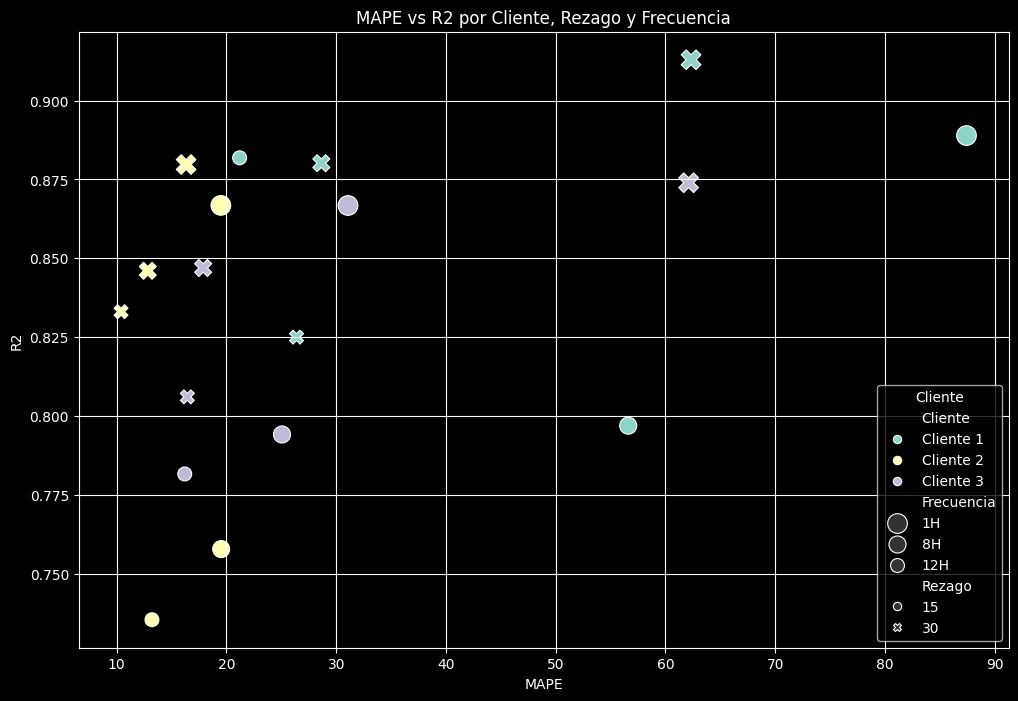

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el gráfico sin configuración de estilo oscuro
plt.figure(figsize=(12, 8))
sns.scatterplot(data=resultados_df, x='MAPE', y='R2', hue='Cliente', style='Rezago', size='Frecuencia', sizes=(100, 200))
plt.title('MAPE vs R2 por Cliente, Rezago y Frecuencia')
plt.xlabel('MAPE')
plt.ylabel('R2')
plt.grid(True)
plt.legend(title='Cliente')
plt.show()

In [47]:
import itertools

# Definir diferentes combinaciones de hiperparámetros
n_estimators_values = [100, 300, 500]
max_depth_values = [10, 20, 30, None]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]
bootstrap_values = [True, False]

# Obtener todas las combinaciones de hiperparámetros
param_combinations = itertools.product(n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values, max_features_values, bootstrap_values)

# Imprimir todas las combinaciones de hiperparámetros
for params in param_combinations:
    print(params)

(100, 10, 2, 1, 'auto', True)
(100, 10, 2, 1, 'auto', False)
(100, 10, 2, 1, 'sqrt', True)
(100, 10, 2, 1, 'sqrt', False)
(100, 10, 2, 1, 'log2', True)
(100, 10, 2, 1, 'log2', False)
(100, 10, 2, 2, 'auto', True)
(100, 10, 2, 2, 'auto', False)
(100, 10, 2, 2, 'sqrt', True)
(100, 10, 2, 2, 'sqrt', False)
(100, 10, 2, 2, 'log2', True)
(100, 10, 2, 2, 'log2', False)
(100, 10, 2, 4, 'auto', True)
(100, 10, 2, 4, 'auto', False)
(100, 10, 2, 4, 'sqrt', True)
(100, 10, 2, 4, 'sqrt', False)
(100, 10, 2, 4, 'log2', True)
(100, 10, 2, 4, 'log2', False)
(100, 10, 5, 1, 'auto', True)
(100, 10, 5, 1, 'auto', False)
(100, 10, 5, 1, 'sqrt', True)
(100, 10, 5, 1, 'sqrt', False)
(100, 10, 5, 1, 'log2', True)
(100, 10, 5, 1, 'log2', False)
(100, 10, 5, 2, 'auto', True)
(100, 10, 5, 2, 'auto', False)
(100, 10, 5, 2, 'sqrt', True)
(100, 10, 5, 2, 'sqrt', False)
(100, 10, 5, 2, 'log2', True)
(100, 10, 5, 2, 'log2', False)
(100, 10, 5, 4, 'auto', True)
(100, 10, 5, 4, 'auto', False)
(100, 10, 5, 4, 'sqrt', 

In [ ]:
# Definir función para evaluación métrica
def evaluacion_metrica(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calcular métricas
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    # Devolver métricas como un diccionario
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

In [ ]:
# Iterar sobre cada cliente ajustando parámetros
resultados_totales = []  # Lista para almacenar los resultados de todos los clientes

for numero_cliente in range(1, 31):
    cliente = 'Cliente ' + str(numero_cliente)
    cliente_df = result_df[result_df['Cliente'] == cliente].copy()
    
    # Ordenar los datos por fecha de manera ascendente
    cliente_df = cliente_df.sort_values(by='Fecha')
    
    # Obtener la columna de 'Active_energy' y establecer 'Fecha' como índice
    data_completa = cliente_df[['Fecha', 'Active_energy']]
    data_completa.set_index('Fecha', inplace=True)
    
    # Iterar sobre diferentes frecuencias y rezagos
    frecuencias = ['1H', '8H', '12H']
    rezagos = [10,15,20,25,30]

    # Seleccionar solo el 90% de los datos
    data_completa = data_completa.iloc[:int(0.9 * len(data_completa))]

    # Crear una lista para almacenar los resultados
    resultados_cliente = []

    for frecuencia in frecuencias:
        # Resample los datos a la frecuencia especificada y sumar la energía activa
        data_completa_diaria = data_completa.resample(frecuencia).sum()

        # Reiniciar el índice para que 'Fecha' sea una columna nuevamente
        data_completa_diaria.reset_index(inplace=True)

        # Agregar columnas de mes y hora
        data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
        data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour

        # Establecer el índice en 'Fecha' y la frecuencia
        data_completa_diaria.set_index('Fecha', inplace=True)
        data_completa_diaria.index.freq = frecuencia

        # Eliminar filas con valores NaN
        data_completa_diaria.dropna(inplace=True)

        for rezago in rezagos:
            # Crear columnas de rezagos para los datos
            data_completa_diaria[f'L{rezago}'] = data_completa_diaria['Active_energy'].shift(rezago)

            # Eliminar filas con valores NaN
            data_completa_diaria.dropna(inplace=True)

            # Definir variables predictoras (X) y variable objetivo (Y)
            X = data_completa_diaria.iloc[:, 1:]
            Y = data_completa_diaria.iloc[:, 0]

            # Dividir datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

            # Definir diferentes combinaciones de hiperparámetros
            n_estimators_values = [100, 300, 500]
            max_depth_values = [10, 20, 30, None]
            min_samples_split_values = [2, 5, 10]
            min_samples_leaf_values = [1, 2, 4]
            bootstrap_values = [True, False]

            # Obtener todas las combinaciones de hiperparámetros
            param_combinations = itertools.product(n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values, max_features_values, bootstrap_values)

            # Iterar sobre cada combinación de hiperparámetros
            for params in param_combinations:
                # Crear y entrenar modelo con la combinación de hiperparámetros
                modelo = RandomForestRegressor(n_estimators=params[0], max_depth=params[1], min_samples_split=params[2], min_samples_leaf=params[3], bootstrap=params[5], n_jobs=-1)
                modelo.fit(X_train, Y_train)

                # Hacer predicciones
                predictions = modelo.predict(X_test)

                # Evaluar métricas de rendimiento
                metricas = evaluacion_metrica(Y_test, predictions)
                
                # Almacenar resultados en la lista
                resultados_cliente.append({
                    'Cliente': cliente,
                    'Frecuencia': frecuencia,
                    'Rezago': rezago,
                    'Modelo': 'Random Forest',
                    'Hiperparametros': params,
                    **metricas,  # Desempaquetar métricas como un diccionario
                    'Len_train': len(X_train),
                    'Len_test': len(X_test),
                    'Len_total': len(data_completa_diaria)
                })

    # Agregar resultados de este cliente a la lista de resultados totales
    resultados_totales.extend(resultados_cliente)

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_totales)

# Mostrar resultados
resultados_df

In [ ]:
resultados_df.to_excel('resultados_clientes_Random_hiperparametros.xlsx', index=False)

In [ ]:
# Filtrar la información para un cliente específico (por ejemplo, 'Cliente 1')
cliente_seleccionado = 'Cliente 1'
resultados_cliente_seleccionado = resultados_df.query("Cliente == @cliente_seleccionado")

# Ordenar las filas según el MAPE de menor a mayor
resultados_cliente_seleccionado_ordenados = resultados_cliente_seleccionado.sort_values(by='MAPE')
resultados_cliente_seleccionado_ordenados

In [39]:
# Excluir las columnas que no son numéricas ('Cliente', 'Modelo') antes de calcular el promedio
columnas_numericas = resultados_df.drop(['Cliente', 'Modelo'], axis=1)

# Calcular el promedio de cada combinación de frecuencia y rezago
promedio_por_combinacion = columnas_numericas.groupby(['Frecuencia', 'Rezago'], as_index=False).min()

# Mostrar el DataFrame resultante
promedio_por_combinacion

,Frecuencia,Rezago,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
0,12H,15,0.085661,0.204688,0.292679,7.354660,-0.842862,524,131,655
1,12H,30,0.089742,0.179175,0.299569,6.252884,-0.408174,500,125,625
2,1H,15,0.002076,0.023335,0.045567,7.886734,-0.218100,6413,1604,8017
3,1H,30,0.001677,0.020896,0.040949,7.753266,-0.098326,6389,1598,7987
4,8H,15,0.082317,0.134000,0.286910,7.741192,-0.290383,791,198,989
5,8H,30,0.035276,0.112599,0.187819,6.232595,-0.312407,767,192,959


In [40]:
# Excluir las columnas que no son numéricas ('Cliente', 'Modelo') antes de calcular el promedio
columnas_numericas = resultados_df.drop(['Cliente', 'Modelo'], axis=1)

# Calcular el promedio de cada combinación de frecuencia y rezago
promedio_por_combinacion = columnas_numericas.groupby(['Frecuencia', 'Rezago'], as_index=False).max()

# Mostrar el DataFrame resultante
promedio_por_combinacion

,Frecuencia,Rezago,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
0,12H,15,224.201931,8.874869,14.973374,171.847545,0.905692,1168,293,1461
1,12H,30,195.212364,7.681390,13.971842,168.624064,0.917800,1144,287,1431
2,1H,15,4.971211,1.776880,2.229621,591.098959,0.947916,14157,3540,17697
3,1H,30,4.135315,1.616009,2.033547,2780.608249,0.942696,14133,3534,17667
4,8H,15,104.233513,6.406425,10.209482,218.812125,0.890431,1759,440,2199
5,8H,30,89.190218,5.663530,9.444057,176.496445,0.904702,1735,434,2169


In [41]:
lower_bound,upper_bound

(array([34.88004214, 37.24662976, 35.46810711, 37.45953664, 44.52356534,
        43.24718992, 41.80813671, 33.66944616, 43.42803271, 44.04059851,
        42.90569558, 42.07671805, 42.85190342, 40.90235338, 37.19163577,
        32.92751322, 36.81510582, 41.92117354, 43.24979625, 43.39323873,
        39.53100842, 42.42441776, 42.75882761, 44.29089079, 43.05374937,
        43.5009974 , 42.47991859, 43.49809306, 35.09569236, 32.68800641,
        40.50863229, 44.18903161, 43.61063745, 43.09647211, 35.29587164,
        42.39756206, 41.94599811, 43.46460399, 43.08990087, 43.26037132,
        43.31083659, 46.71595573, 35.08844357, 33.52011784, 36.68714634,
        41.84458525, 41.69061809, 44.45628189, 44.00289496, 42.68975667,
        42.54175443, 43.60412676, 43.45568986, 42.66700029, 41.51439233,
        41.86869426, 34.54293242, 34.78124859, 34.52671502, 43.61157337,
        44.40048538, 42.51127282, 44.00852545, 43.6396599 , 42.76908413,
        41.77727904, 43.41734216, 43.01405023, 43.0

In [42]:
# Convertir las predicciones y los intervalos de confianza en DataFrames con el mismo índice que test_feature
fcst_df = pd.DataFrame(fcst, index=test_target.index, columns=['Predicted'])
lower_bound_df = pd.DataFrame(lower_bound, index=test_feature.index, columns=['Lower_Bound'])
upper_bound_df = pd.DataFrame(upper_bound, index=test_feature.index, columns=['Upper_Bound'])

# Combinar test_feature, fcst_df, lower_bound_df y upper_bound_df en un solo DataFrame
combined_df = pd.concat([test_target, fcst_df, lower_bound_df, upper_bound_df], axis=1)
combined_df['anomalias'] = ((combined_df['Active_energy'] > combined_df['Upper_Bound']) |
                            (combined_df['Active_energy'] < combined_df['Lower_Bound']))

# Imprimir el DataFrame resultante
combined_df.head(5)


,Active_energy,Predicted,Lower_Bound,Upper_Bound,anomalias
Fecha,,,,,
2022-10-22 00:00:00,43.452680,43.600053,34.880042,52.320063,False
2022-10-22 12:00:00,33.054786,46.558287,37.246630,55.869945,True
2022-10-23 00:00:00,44.379023,44.335134,35.468107,53.202161,False
2022-10-23 12:00:00,51.204228,46.824421,37.459537,56.189305,False
2022-10-24 00:00:00,62.034365,55.654457,44.523565,66.785348,False


In [43]:
resumen_anomalias = combined_df['anomalias'].value_counts()
resumen_anomalias

anomalias
False    286
True      37
Name: count, dtype: int64

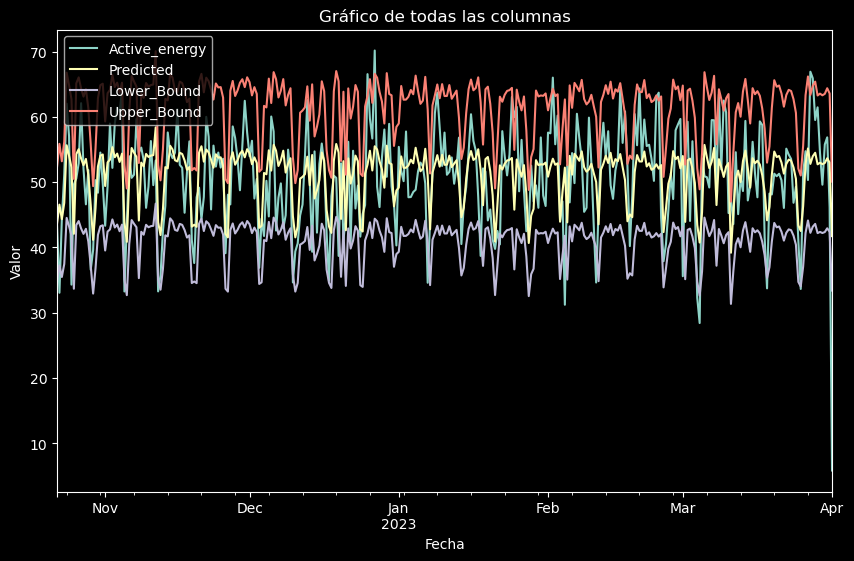

In [44]:
# # Graficar todas las columnas de combined_df
# combined_df.plot(subplots=True, figsize=(10, 10))
# plt.show()

combined_df.plot(figsize=(10, 6))
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Gráfico de todas las columnas')
plt.legend(loc='upper left')
plt.show()



In [45]:
importances = rfr.feature_importances_

# Si tienes los nombres de las características, es útil usarlos para hacer los resultados más interpretables
feature_names = train_feature.columns

# Creamos un DataFrame para visualizar mejor las importancias
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenamos el DataFrame basado en la importancia de manera descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostramos el DataFrame
feature_importance_df.head(10)


ValueError: All arrays must be of the same length

In [ ]:
# # Graficar las importancias
# plt.figure(figsize=(10, 8))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
# plt.xlabel('Importance')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
# plt.show()

### Calibración parametros Random Forest

In [ ]:
# Crear el DataFrame vacío
calibracion_modelo = pd.DataFrame(columns=['Modelo', 'Cliente', 'Parametros', 'MSE', 'MAE', 'RMSE', 'MAPE', 'R2'])

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Definir el scorer utilizando la función de MAPE
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [ ]:
param_grid = {
    'n_estimators': [100,300,500],
    'max_depth': [10, 20, 30, None],  # None significa que los árboles pueden crecer tanto como sea necesario
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]  # Si se debe utilizar bootstrap para construir los árboles
}

# Creamos el modelo base con 500 árboles y uso de todos los núcleos disponibles
rfr = RandomForestRegressor()

# Configuración del GridSearchCV con el scorer de MAPE
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=3, scoring=mape_scorer, n_jobs=-1, verbose=2)

# Ajuste del GridSearchCV
grid_search.fit(train_feature, train_target)


In [ ]:
grid_search.cv_results_.keys()

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']MSE= grid_search.cv_results_['mean_test_mse'],
MAE= grid_search.cv_results_['mean_test_mae'],
RMSE= grid_search.cv_results_['mean_test_rmse'],
MAPE=grid_search.cv_results_['mean_test_mape'],
R2= grid_search.cv_results_['mean_test_r2']


# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Seleccionar el mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
fcst = best_model.predict(test_feature)

In [ ]:
evaluacion_metrica(test_target,fcst)

### Calibración parametros XGB

In [37]:
# Iterar sobre cada cliente ajustando parámetros
import itertools
resultados_totales = []  # Lista para almacenar los resultados de todos los clientes

for numero_cliente in range(1, 31):
    cliente = 'Cliente ' + str(numero_cliente)
    cliente_df = result_df[result_df['Cliente'] == cliente].copy()
    
    # Ordenar los datos por fecha de manera ascendente
    cliente_df = cliente_df.sort_values(by='Fecha')
    
    # Obtener la columna de 'Active_energy' y establecer 'Fecha' como índice
    data_completa = cliente_df[['Fecha', 'Active_energy']]
    data_completa.set_index('Fecha', inplace=True)
    
    # Iterar sobre diferentes frecuencias y rezagos
    frecuencias = ['1H', '8H', '12H']
    rezagos = [10,15,20,25,30]

    # Seleccionar solo el 90% de los datos
    data_completa = data_completa.iloc[:int(0.9 * len(data_completa))]

    # Crear una lista para almacenar los resultados
    resultados_cliente = []

    for frecuencia in frecuencias:
        # Resample los datos a la frecuencia especificada y sumar la energía activa
        data_completa_diaria = data_completa.resample(frecuencia).sum()

        # Reiniciar el índice para que 'Fecha' sea una columna nuevamente
        data_completa_diaria.reset_index(inplace=True)

        # Agregar columnas de mes y hora
        data_completa_diaria['Month'] = data_completa_diaria['Fecha'].dt.month
        data_completa_diaria['Hour'] = data_completa_diaria['Fecha'].dt.hour

        # Establecer el índice en 'Fecha' y la frecuencia
        data_completa_diaria.set_index('Fecha', inplace=True)
        data_completa_diaria.index.freq = frecuencia

        # Eliminar filas con valores NaN
        data_completa_diaria.dropna(inplace=True)

        for rezago in rezagos:
            # Crear columnas de rezagos para los datos
            data_completa_diaria[f'L{rezago}'] = data_completa_diaria['Active_energy'].shift(rezago)

            # Eliminar filas con valores NaN
            data_completa_diaria.dropna(inplace=True)

            # Definir variables predictoras (X) y variable objetivo (Y)
            X = data_completa_diaria.iloc[:, 1:]
            Y = data_completa_diaria.iloc[:, 0]

            # Dividir datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

            # Definir diferentes combinaciones de hiperparámetros
            n_estimators = [100, 300]
            max_depth = [3, 5, 6]  # Profundidad máxima del árbol
            learning_rate = [0.01]  # Tasa de aprendizaje
            subsample = [0.8, 0.9]  # Proporción de muestras usadas para ajustar cada árbol
            colsample_bytree = [0.8, 0.9]  # Proporción de características usadas para ajustar cada árbol
            gamma = [0, 0.1]  # Mínima reducción de pérdida requerida para dividir un nodo

            # Obtener todas las combinaciones de hiperparámetros
            param_combinations = itertools.product(n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma)

            # Iterar sobre cada combinación de hiperparámetros
            for params in param_combinations:
                # Crear y entrenar modelo con la combinación de hiperparámetros
                modelo = XGBRegressor(n_estimators=params[0], max_depth=params[1], learning_rate=params[2], subsample=params[3], colsample_bytree=params[4],gamma=params[5], n_jobs=-1)
                modelo.fit(X_train, Y_train)

                # Hacer predicciones
                predictions = modelo.predict(X_test)

                # Evaluar métricas de rendimiento
                metricas = evaluacion_metrica(Y_test, predictions)
                
                # Almacenar resultados en la lista
                resultados_cliente.append({
                    'Cliente': cliente,
                    'Frecuencia': frecuencia,
                    'Rezago': rezago,
                    'Modelo': 'XGB',
                    'Hiperparametros': params,
                    **metricas,  # Desempaquetar métricas como un diccionario
                    'Len_train': len(X_train),
                    'Len_test': len(X_test),
                    'Len_total': len(data_completa_diaria)
                })

    # Agregar resultados de este cliente a la lista de resultados totales
    resultados_totales.extend(resultados_cliente)

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_totales)

# Mostrar resultados
resultados_df

C:\Users\dhoyoso\AppData\Local\Temp\ipykernel_19640\313429164.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_completa_diaria = data_completa.resample(frecuencia).sum()
C:\Users\dhoyoso\AppData\Local\Temp\ipykernel_19640\313429164.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_completa_diaria.index.freq = frecuencia
C:\Users\dhoyoso\AppData\Local\Temp\ipykernel_19640\313429164.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_completa_diaria = data_completa.resample(frecuencia).sum()
C:\Users\dhoyoso\AppData\Local\Temp\ipykernel_19640\313429164.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_completa_diaria.index.freq = frecuencia
C:\Users\dhoyoso\AppData\Local\Temp\ipykernel_19640\313429164.py:28: FutureWarning: 'H' is deprecated and 

,Cliente,Frecuencia,Rezago,Modelo,Hiperparametros,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
0,Cliente 1,1H,10,XGB,"(100, 3, 0.01, 0.8, 0.8, 0)",0.996292,0.725796,0.998144,88.265484,0.559313,14161,3541,17702
1,Cliente 1,1H,10,XGB,"(100, 3, 0.01, 0.8, 0.8, 0.1)",0.996292,0.725796,0.998144,88.265484,0.559313,14161,3541,17702
2,Cliente 1,1H,10,XGB,"(100, 3, 0.01, 0.8, 0.9, 0)",0.996292,0.725796,0.998144,88.265484,0.559313,14161,3541,17702
3,Cliente 1,1H,10,XGB,"(100, 3, 0.01, 0.8, 0.9, 0.1)",0.996292,0.725796,0.998144,88.265484,0.559313,14161,3541,17702
4,Cliente 1,1H,10,XGB,"(100, 3, 0.01, 0.9, 0.8, 0)",0.995931,0.725574,0.997964,88.309032,0.559472,14161,3541,17702
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,Cliente 30,12H,30,XGB,"(300, 6, 0.01, 0.8, 0.9, 0.1)",6.771555,1.851243,2.602221,13.498448,0.829031,605,152,757
21596,Cliente 30,12H,30,XGB,"(300, 6, 0.01, 0.9, 0.8, 0)",6.633312,1.847941,2.575522,13.575379,0.832521,605,152,757
21597,Cliente 30,12H,30,XGB,"(300, 6, 0.01, 0.9, 0.8, 0.1)",6.635846,1.846801,2.576014,13.566319,0.832457,605,152,757
21598,Cliente 30,12H,30,XGB,"(300, 6, 0.01, 0.9, 0.9, 0)",6.743366,1.845663,2.596799,13.531148,0.829743,605,152,757


In [38]:
resultados_df.sort_values(by='MAPE', ascending=True)

,Cliente,Frecuencia,Rezago,Modelo,Hiperparametros,MSE,MAE,RMSE,MAPE,R2,Len_train,Len_test,Len_total
19082,Cliente 27,8H,20,XGB,"(300, 3, 0.01, 0.8, 0.9, 0)",2.807298,1.013428,1.675499,6.017004,0.727689,992,248,1240
19080,Cliente 27,8H,20,XGB,"(300, 3, 0.01, 0.8, 0.8, 0)",2.807298,1.013428,1.675499,6.017004,0.727689,992,248,1240
19081,Cliente 27,8H,20,XGB,"(300, 3, 0.01, 0.8, 0.8, 0.1)",2.807593,1.013464,1.675587,6.017201,0.727661,992,248,1240
19083,Cliente 27,8H,20,XGB,"(300, 3, 0.01, 0.8, 0.9, 0.1)",2.807593,1.013464,1.675587,6.017201,0.727661,992,248,1240
19084,Cliente 27,8H,20,XGB,"(300, 3, 0.01, 0.9, 0.8, 0)",2.769604,1.015252,1.664213,6.027924,0.731346,992,248,1240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14419,Cliente 21,1H,10,XGB,"(100, 6, 0.01, 0.8, 0.9, 0.1)",0.030413,0.171947,0.174392,18275.164105,-21.218537,6417,1605,8022
14407,Cliente 21,1H,10,XGB,"(100, 3, 0.01, 0.9, 0.9, 0.1)",0.030412,0.171942,0.174389,18276.251009,-21.217748,6417,1605,8022
14405,Cliente 21,1H,10,XGB,"(100, 3, 0.01, 0.9, 0.8, 0.1)",0.030412,0.171942,0.174389,18276.251009,-21.217748,6417,1605,8022
14401,Cliente 21,1H,10,XGB,"(100, 3, 0.01, 0.8, 0.8, 0.1)",0.030412,0.171943,0.174390,18279.427340,-21.217810,6417,1605,8022


In [39]:
resultados_df.to_excel('resultados_clientes_XGB_hiperparametros_imputando.xlsx', index=False)

In [40]:
evaluacion_metrica(test_target,predictions)

ValueError: Found input variables with inconsistent numbers of samples: [323, 152]

## Generación Amonalias

In [ ]:
#Umbral de detección de anomalias
upper_bound = (fcst*1.2)
lower_bound = (fcst*0.8)


In [ ]:
# Convertir las predicciones y los intervalos de confianza en DataFrames con el mismo índice que test_feature
fcst_df = pd.DataFrame(fcst, index=test_target.index, columns=['Predicted'])
lower_bound_df = pd.DataFrame(lower_bound, index=test_feature.index, columns=['Lower_Bound'])
upper_bound_df = pd.DataFrame(upper_bound, index=test_feature.index, columns=['Upper_Bound'])

# Combinar test_feature, fcst_df, lower_bound_df y upper_bound_df en un solo DataFrame
combined_df = pd.concat([test_target, fcst_df, lower_bound_df, upper_bound_df], axis=1)
combined_df['anomalias'] = ((combined_df['Active_energy'] > combined_df['Upper_Bound']) |
                            (combined_df['Active_energy'] < combined_df['Lower_Bound']))

# Imprimir el DataFrame resultante
combined_df.head(5)


In [ ]:
resumen_anomalias = combined_df['anomalias'].value_counts()
resumen_anomalias

In [ ]:
# # Graficar todas las columnas de combined_df
# combined_df.plot(subplots=True, figsize=(10, 10))
# plt.show()

combined_df.plot(figsize=(10, 6))
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Gráfico de todas las columnas')
plt.legend(loc='upper left')
plt.show()

